In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [2]:
# Load the datasets
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

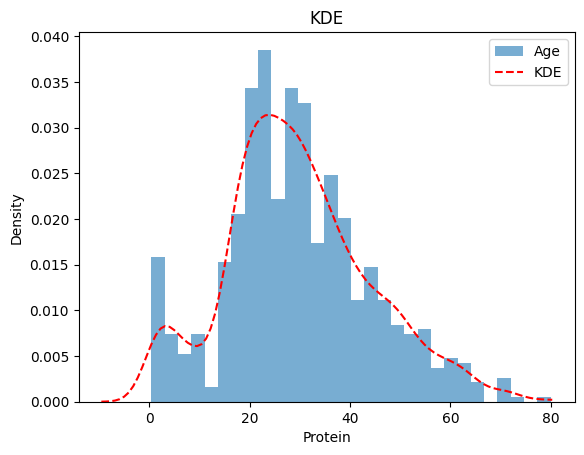

In [3]:
#Using KDE to estimate missing age data
age = df_train['Age'].dropna()
age_data = age.to_numpy()
from scipy.stats import norm
#KDE function
def kde(x, sigma, data):
    n = len(data)
    mixture = 0
    for i in range(n):
        mixture = mixture + norm.pdf(x, data[i], sigma)
    return mixture/n
#Finding range
x_range = np.linspace(min(age_data)-10, max(age_data)+0.3, 100)
#Sigma for KDE
sig = 3
#KDE PDF
kde_pdf = kde(x_range, sig, age_data)

#Plot histogram of age data
plt.hist(age_data, bins=30, density=True, alpha=0.6, label='Age')
#plot KDE
plt.plot(x_range, kde_pdf, linestyle='--', label='KDE', color='red')
plt.title('KDE')
plt.xlabel('Protein')
plt.ylabel('Density')
plt.legend()
plt.show()

Sample Mean: 48.601019022486085


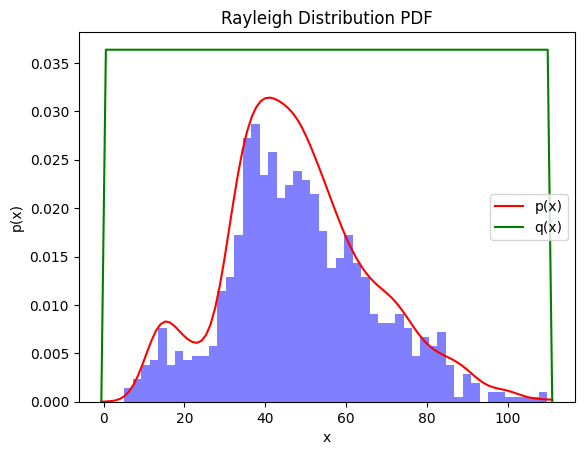

In [4]:
#Performing Rejection Sampling
from scipy.stats import uniform
from numpy.random import rand

# Interpolating KDE
def p(x):
    return np.interp(x, x_range, kde_pdf)

def q(x):
    return uniform.pdf(x, loc=min(age_data), scale=max(age_data) + 30)

#Choosing a k where k*q(x) >= p(x)
k = 4
#Finding range
x_range = np.linspace(min(age_data)-1, max(age_data)+31, 100)

#rejection sampling algorithm
def rej_smpl(n):
    samples = []
    while len(samples) < n:
        sample = np.random.uniform(min(age_data), max(age_data) + 30)
        if (k*q(sample)*rand()) < p(sample):
            samples.append(sample)
    return samples

#generating 1000 samples
final_samples = rej_smpl(1000)
sample_mean = np.mean(final_samples)

print('Sample Mean:', sample_mean)

# Plot the function and visualising  samples
plt.hist(final_samples, bins=50, density=True, color='blue', alpha=0.5)
plt.plot(x_range, kde_pdf, label=f'p(x)', color='red')
plt.plot(x_range, k*q(x_range), label=f'q(x)', color='green')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.title('Rayleigh Distribution PDF')
plt.legend()
plt.show()

In [5]:
#replace age column with new data
df_train_main['Age'].fillna(np.random.choice(final_samples))
#dropping NA value
df_train_main = df_train_main.dropna()
#initialising y vector
y = np.array(df_train['Survived']).reshape(-1,1)
#dropping Irrelivent data - Ticket & Cabin to be added later
df_train_main = df_train.drop(['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1)
#one-hot encoding catagorical features
oh_sex = pd.get_dummies(df_train_main['Sex'], drop_first=True, dtype=int)
oh_embarked = pd.get_dummies(df_train_main['Embarked'], drop_first=True, dtype=int)
#dropping catagorical features
df_train_main = df_train_main.drop(['Sex', 'Embarked'], axis = 1)
#converting to numpy and scaling data
oh_sex = oh_sex.to_numpy()
oh_embarked = oh_embarked.to_numpy()
X = df_train_main.to_numpy()
X_scale = preprocessing.scale(X)
#Concatinating data and adding bias column
bias = np.ones((X_scale.shape[0], 1))
Phi = np.hstack((oh_sex, oh_embarked, X_scale, bias))
print(Phi.shape)

(712, 9)


In [6]:
#Splitting data for validation
#80/20 split between training and rest of data
[Phi_train, Phi_rest, y_train, y_rest] = train_test_split(Phi, y, test_size = .2)
#50/50 split between validation and test data
[Phi_val, Phi_test, y_val, y_test] = train_test_split(Phi_rest, y_rest, test_size = .5)

ValueError: Found input variables with inconsistent numbers of samples: [712, 891]